# EE6132: Programming Assignment-1: Canny Edge Detection

**Submitted by Chitranshu Vashishth [ME17B105]**

## You are required to implement the canny edge detection algorithm as described in class. Please follow the steps mentioned below.

### Importing Necessary Libraries

In [1]:
import warnings
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### (a) Read the image ‘clown.jpeg’ and display it.


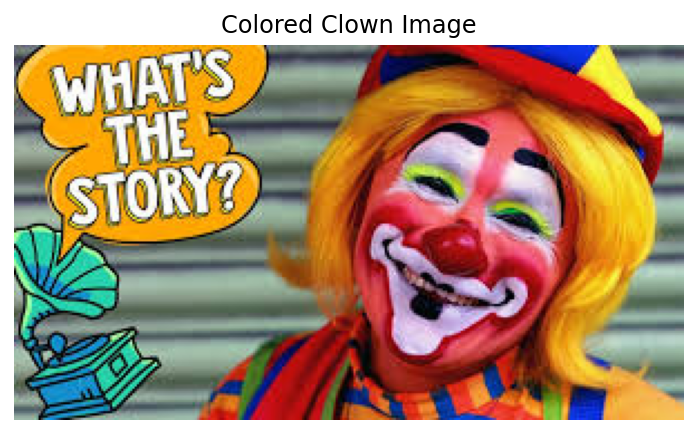

In [2]:
img = cv2.imread('./clown.jpeg')

fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
ax.set_title("Colored Clown Image")
ax.axis('off');

By default OpenCV imports image in BGR format. Since our original image is in RGB format ```cvtColor``` was used to transform that into original form and output that

### (b) Convert it into a grayscale image.

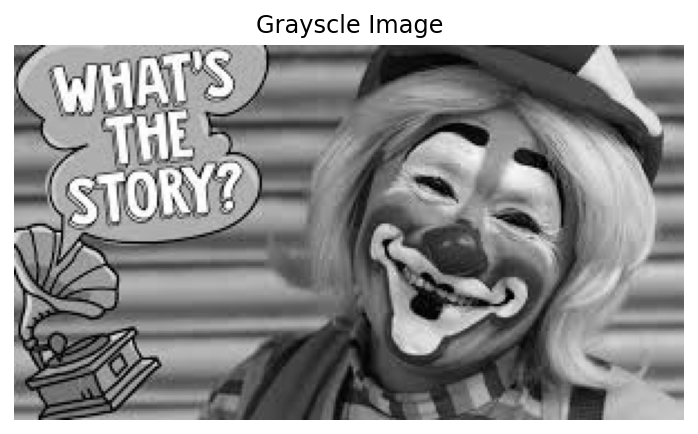

In [3]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray');
ax.set_title("Grayscle Image")
ax.axis('off');

The conversion algorithm for each pixel of the image conversion to grayscale is

$Y = 0.114B + 0.587G + 0.299R$ 

By default matplotlib gray output isn't in shades of grey so cmap='gray' is used 

### (c) To suppress the noise use a Gaussian kernel to smoothen it. Keep the kernel size as 5 × 5 and sigma = 1.5.


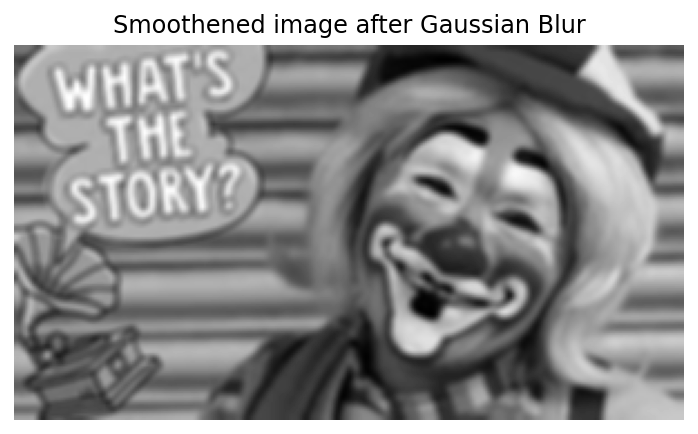

In [4]:
img = cv2.GaussianBlur(img, (5, 5), 1.5)

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray');
ax.set_title("Smoothened image after Gaussian Blur")
ax.axis('off');

Using OpenCV Gaussian Blur method of size 5*5 and sigma=1.5 to supress the noise

### (d) Apply the standard Sobel operator Gx and Gy discussed in class. Display the filtered outputs. Also show the gradient magnitude and angle images.


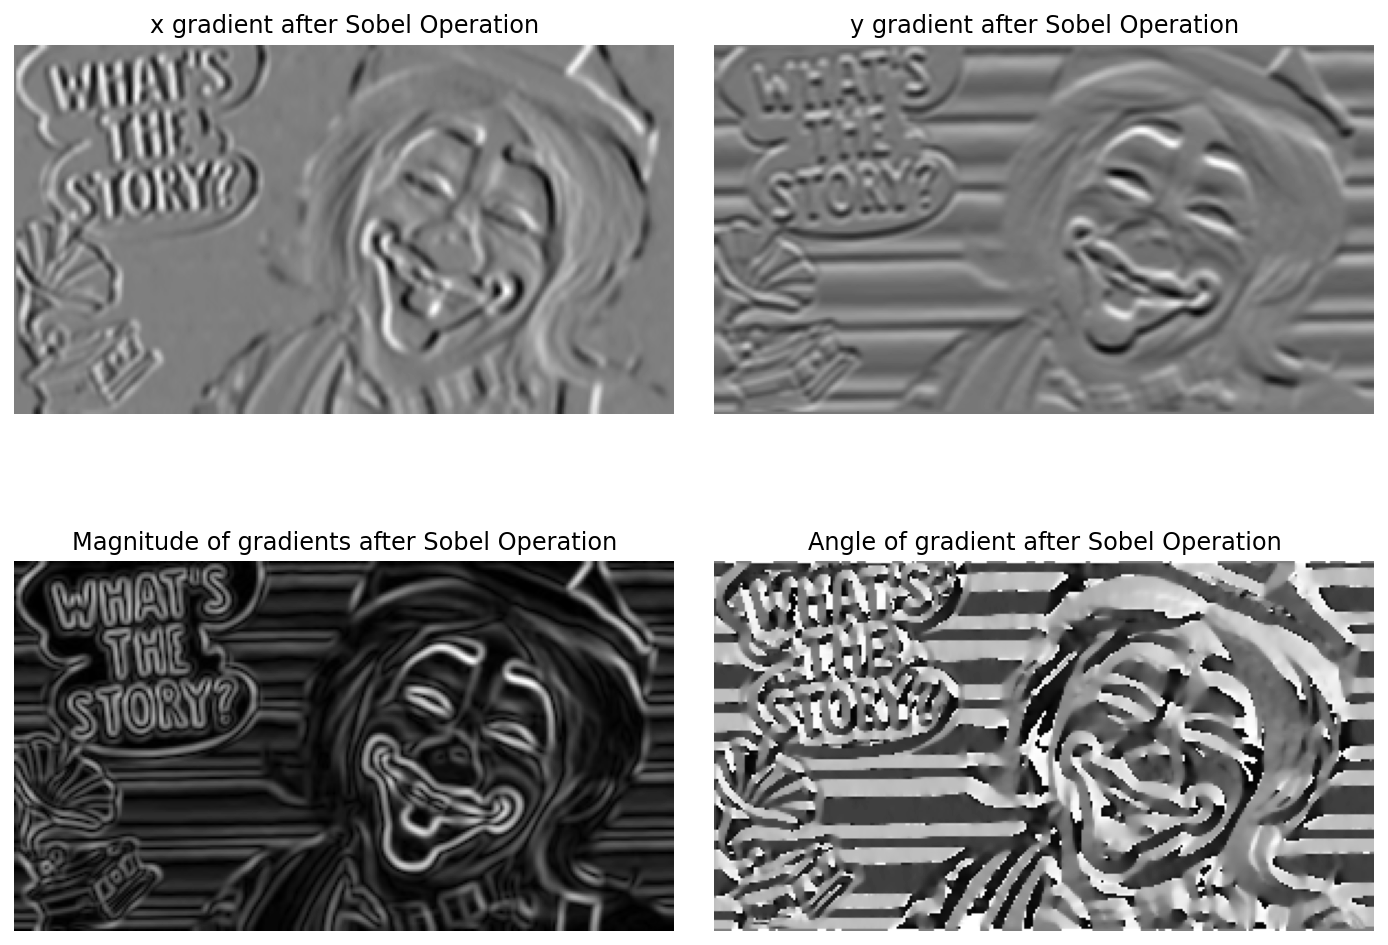

In [5]:
Gx = cv2.Sobel(np.float64(img), cv2.CV_64F, 1, 0, ksize=3)
Gy = cv2.Sobel(np.float64(img), cv2.CV_64F, 0, 1, ksize=3)

G = np.sqrt(np.square(Gx) + np.square(Gy))
G = G/G.max() * 255  # Normalizing the pixel values in 0-255 range

theta = np.arctan2(Gy, Gx)  # theta values are in -pi to pi range.

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.flatten()

ax[0].imshow(Gx, cmap='gray');
ax[0].set_title("x gradient after Sobel Operation")
ax[0].axis('off');

ax[1].imshow(Gy, cmap='gray');
ax[1].set_title("y gradient after Sobel Operation")
ax[1].axis('off');

ax[2].imshow(G, cmap='gray');
ax[2].set_title("Magnitude of gradients after Sobel Operation")
ax[2].axis('off');

ax[3].imshow(theta, cmap='gray');
ax[3].set_title("Angle of gradient after Sobel Operation")
ax[3].axis('off');

plt.tight_layout(pad=2)

- Sobel Operations in x and y direction convolve the image with kernels $K_x$ and $K_y$ respectively to give us gradient in each direction

$K_x$ = $\begin{bmatrix} 
-1 & 0 & 1 \\
-2 & 0 & 2\\
-1 & 0 & 1 \\
\end{bmatrix}$

$K_y$ = $\begin{bmatrix} 
-1 & -2 & -1 \\
0 & 0 & 0\\
1 & 2 & 1 \\
\end{bmatrix}$



 
- The magnitude of the gradient of each pixel is calculated as normalized value of $|G| = \sqrt{G_x^2 + G_y^2}$. 

- Here $G_x$ and $G_y$ are the convolved images formed after operations of image with $K_x$ and $K_y$

- The angle $\theta$ is calculated as $\tan^{-1}\left(\frac{G_y}{G_x}\right)$ on each element of these matrices.


**Warning** - ``imshow`` method of ``pyplot`` module works by taking an array and normalizing it values in 0-1 scale and then upscaling those values to 0-255 range. If we deny this normalization and have raw output of pixel shown as image we may run into the problem of lots of pixels just being pure white or pure black because of how close they are to the extreme values. Hence we allowed normalization. Otherwise most of the values in ``theta
`` would look almost black

### (e) Apply non-maximum suppression as discussed in class. The exact method requires computing the imaginary pixels shown in gray in the image below using interpolation methods such as bilinear and bicubic interpolation. As a simplification just locate the image pixels which are spatially closest to the imaginary gray pixels and use those pixels as the neighboring pixels for non-maxima suppression. This way you can bypass the interpolation step and have a computationally lighter method if you so desire. Show the Non-Maximum Suppression output.

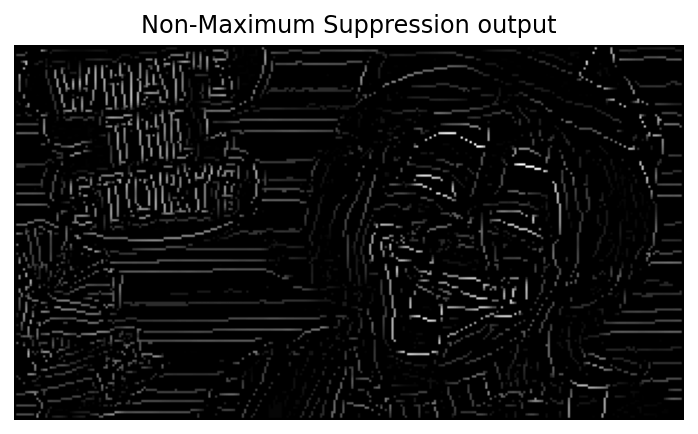

In [6]:
M, N = img.shape
Z = np.zeros((M, N), dtype=np.int32)

# Converting all angles in degrees
angle = theta * 180. / np.pi

# Since tan is a periodic function with period 180 degrees
# We can add 180 to the values which are in -180 to 0 range
angle[angle < 0] += 180

q = 255
r = 255

for i in range(1, M-1):
    for j in range(1, N-1):

        # 0 or 180 degree gradient direction
        if(0 <= angle[i, j] <= 22.5) or (157.5 <= angle[i, j] <= 180):
            q = G[i, j+1]  # +ve x direction
            r = G[i, j-1]  # -ve x direction

        # 45 degree gradient direction
        elif(22.5 <= angle[i, j] <= 67.5):
            q = G[i-1, j+1]  # 1st quadrant
            r = G[i+1, j-1]  # 3rd quadrant

        # 90 degree gradient direction
        elif(67.5 <= angle[i, j] <= 112.5):
            q = G[i+1, j]  # +ve y direction
            r = G[i-1, j]  # -ve y direction

        # 135 degree gradient direction
        elif(112.5 <= angle[i, j] <= 157.5):
            q = G[i+1, j+1]  # 4th quadrant
            r = G[i-1, j-1]  # 2nd quadrant

        if (G[i, j] >= q) and (G[i, j] >= r):
            Z[i, j] = G[i, j]
        else:
            Z[i, j] = 0

fig, ax = plt.subplots()
ax.imshow(Z, cmap='gray');
ax.set_title("Non-Maximum Suppression output")
ax.axis('off');

The non maximum suppression process requires 8 neighborhood. The concept is fairly straightforward. For each pixel, we check the orientation. We are going to see if this pixel is more intense than its neighbor of its gradient’s direction. if yes, then we compare the pixel with its neighbor in the opposite direction. If this pixel has the maximum intensity compared to its two-directional neighbors, then it is the local maximum. This pixel will be kept. In all other cases, it is not a local maximum and the pixel is removed.


### (f) Instead of using the Double thresholding Hysteresis used in the exact algorithm simply do a single thresholding operation. Pixels with values less than the threshold should be suppressed. Use the median value of the magnitude image computed in Step d as the threshold value. Show the final output.

The threshold value for supression is 36.35


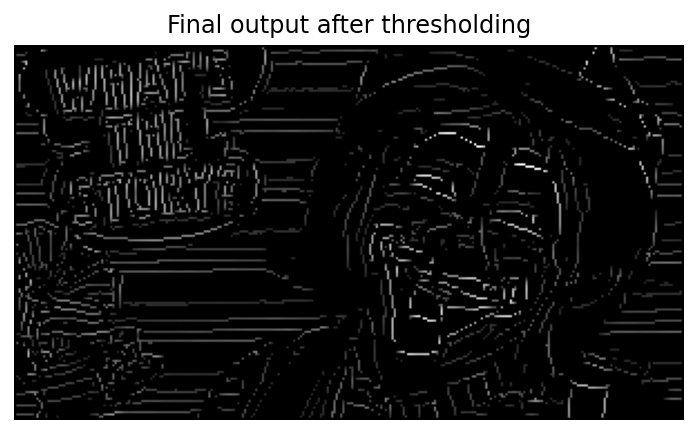

In [7]:
M, N = Z.shape
res = np.zeros((M, N), dtype=np.int32)

threshold = np.median(G.flatten())

active_i, active_j = np.where(Z >= threshold)

res[active_i, active_j] = Z[active_i, active_j]

print(f"The threshold value for supression is {round(threshold,2)}")

fig, ax = plt.subplots()
ax.imshow(res, cmap='gray');
ax.set_title("Final output after thresholding")
ax.axis('off');

fig.savefig('out.png', bbox_inches='tight', pad_inches=0)

I created a new array ``res`` of all pixel values as zeroes and copied pixel values from $Z$ matrix after Non-Maximum Suppression which were greater than the threshold. The threshold in this case is the median of the flattened array of gradient magnitude $G$ ndarray.

Comparing the images, after the final output and the one after Non-Maximum Suppression, one can clearly see that light grey edges of weak intensity were supressed and that resulted in much finer output image in the end after thresholding

## Repeat the above question but increase the sigma of the Gaussian kernel to 3. Choose your filter size appropriately. Just show the final output for this question. How does the final output differ from that of the previous question?




![Final Output with Guassian Blur sigma = 1.5](out.png "sigma = 1.5")


![Final Output with Guassian Blur sigma = 3](out2.png "sigma = 3")


The final output of canny edge detector with Gaussian Blur sigma = 3 differs slightly from the one with sigma=1.5. The threshold value with respect to which pixels were suppressed in Q1 (f) section is different in case of second image. The threshold value is 40.21 in latter case instead of 36.35 in the previous case. By increasing the value of sigma in the Gaussian Blurring process we made the image more blurred making the edge thinning (non maximum suppression) process more aggressive and miss out other finer details and only allowed prominient edges. This made the image get rid of lot of smaller finer edges which may not be needed usually. The final edge image also looks much noisier because the gradient magnitude of the blurred image (sigma=3) didn't result in exact representation of edges of original image. We got good localization and single response but there seems to be lack of good detection in this process. There is often a tradeoff between getting accurate representation of edges vs noise and it usually depends on the context of the problem.

---
---